In [1]:
import importlib
from libs import trades, plots, params
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)

import sys
print(sys.executable)

import math
import pandas as pd
from pandas import Timestamp
import numpy as np
import glob
import os
import datetime as dt
from datetime import datetime
from pprint import pprint
from collections import OrderedDict

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import display, HTML

from typing import Optional, Dict, Tuple, List, Sequence
from sklearn.preprocessing import StandardScaler

from tqdm.auto import tqdm
tqdm.pandas()        

pd.set_option('display.max_columns', None)

display(HTML("""
<style>
.output_scroll {
    overflow-y: visible !important;
    max-height: none !important;
}
</style>
"""))


/usr/bin/python


/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
ticker = params.ticker
folder = "Intraday stocks" 

bidasktoclose_spread = 0.03

date_to_check = None
date_to_check = '2017-06' # if 'None' (just comment this line) all dates to be analyzed and final merged CSV to be saved

dfs training/GOOGL_base.csv already exists. Reading and plotting the processed data...


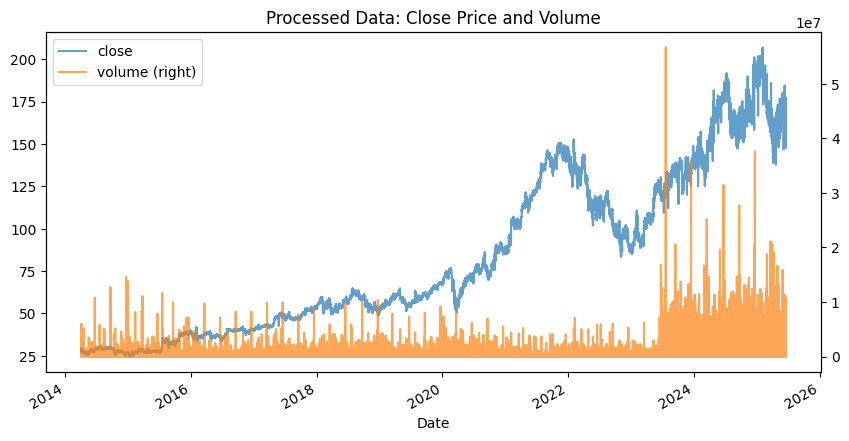

reference_gain 0.021259211873474328


open      high       low     close   volume  \
datetime                                                               
2014-04-03 10:42:00   28.6500   28.6500   28.6500   28.6500   2000.0   
2014-04-03 10:43:00   28.6500   28.6500   28.6500   28.6500   2000.0   
2014-04-03 11:04:00   28.6500   28.6500   28.6500   28.6500  11220.0   
2014-04-03 11:05:00   28.6500   28.6500   28.6500   28.6500   4620.0   
2014-04-03 11:34:00   28.5005   28.5005   28.5005   28.5005   3460.0   
...                       ...       ...       ...       ...      ...   
2025-06-18 23:55:00  173.9000  173.9445  173.8670  173.8681   3136.0   
2025-06-18 23:56:00  173.8200  173.9500  173.7900  173.9000    183.0   
2025-06-18 23:57:00  173.9500  173.9500  173.8600  173.8601    240.0   
2025-06-18 23:58:00  173.8600  173.9000  173.8600  173.8600    327.0   
2025-06-18 23:59:00  173.8700  173.8700  173.8600  173.8700    124.0   

                            ask         bid  
datetime                                     
2014-04-03 10:42:00   28.658595   28.641405  
2014-04-03 10:43:00   28.658595   28.641405  
2014-04-03 11:04:00   28.658595   28.641405  
2014-04-03 11:05:00   28.658595   28.641405  
2014-04-03 11:34:00   28.509050   28.491950  
...                         ...         ...  
2025-06-18 23:55:00  173.920300  173.815900  
2025-06-18 23:56:00  173.952200  173.847800  
2025-06-18 23:57:00  173.912300  173.807900  
2025-06-18 23:58:00  173.912200  173.807800  
2025-06-18 23:59:00  173.922200  173.817800  

[1462494 rows x 7 columns]

In [3]:
# first process of the dataframe, adding artificial bid and ask prices, and correcting possible price splits

df = trades.process_splits(folder=folder, 
                                ticker=ticker, 
                                bidasktoclose_spread=bidasktoclose_spread,
                                vol_fact=1)

reference_gain = trades.compute_reference_gain(df)

print('reference_gain', reference_gain)

df

In [4]:

def saveDF_checkDAY(
    df,
    ticker,
    min_prof_thr,
    max_down_prop,
    gain_tightening_factor,
    smooth_win_sig,
    pre_entry_decay,
    buy_threshold,
    trailing_stop_thresh,
    merging_retracement_thr,
    merging_time_gap_thr,
    reference_gain,
    keep_cols=None,
    date_to_check=None
):
    """
    Modes:
      • Month ('YYYY-MM')   → process each day, then summary  
      • Day   ('YYYY-MM-DD')→ process that day only  
      • None  → full‐run: smooth ALL, pipeline, merge+interpolate w/ progress, save CSV  
    """
    if keep_cols is None:
        keep_cols = [
            "open","high","low","close","volume",
            "bid","ask","signal_action",
            "StrategyEarning","EarningDiff","signal_smooth"
        ]

    performance_list = []

    # -------------------------------------------------------------------------
    # Process exactly one calendar day
    # -------------------------------------------------------------------------
    def process_single_day(day_str):
        print(f"\n=== Processing trading day {day_str} ===")
        day_dt = pd.to_datetime(day_str)
        day_df = df.loc[df.index.normalize() == day_dt].copy()
        if day_df.empty:
            print(" no data; skipping.")
            return

        try:
            day_df_prep = trades.prepare_interpolate_data( 
                df=day_df,
                regular_start=params.regular_start,
                regular_end=params.regular_end
            )
        except ValueError as ve:
            if "window 0" in str(ve):
                print(" warning: smoothing window=0; skipping smoothing.")
            else:
                raise

        result = trades.run_trading_pipeline(day_df_prep, 
                                             col_signal='signal_smooth',
                                             col_action='signal_action',
                                             reference_gain=reference_gain, 
                                             day_to_check=day_str)
        if result is None:
            print(" no trades found; skipping.")
            return

        df_day, trades_day, perf_day = result
        plots.plot_trades(
            df=df_day,
            col_signal1='signal_scaled',
            col_signal2='signal_smooth',
            col_action='signal_action',
            trades=trades_day,
            buy_threshold=buy_threshold,
            performance_stats=perf_day
        )

        print(f"\n=== Performance for {day_dt} ===")
        for k, v in perf_day.items():
            print(f"{k}: {v}")

        performance_list.append(perf_day)

    if date_to_check:
        # Month mode: 'YYYY-MM'
        if len(date_to_check) == 7:
            print(f"\nMonth mode: processing {date_to_check}")

            # 1) collect all days in this month
            days = (
                df.loc[df.index.strftime("%Y-%m") == date_to_check]
                  .index.normalize()
                  .unique()
            )
            for d in sorted(days.astype(str)):
                process_single_day(d)

            # 2) aggregate your per-day stats
            monthly_summary = plots.aggregate_performance(performance_list)

            # 3) find first & last day, then their session-close prices
            start_date = days.min()
            end_date   = days.max()

            # first bar at or after regular_start on the first day
            start_ask = df.loc[
                (df.index.normalize() == start_date) &
                (df.index.time     >= params.regular_start),
                "ask"
            ].iloc[0]

            # last bar before regular_end on the last day
            end_bid = df.loc[
                (df.index.normalize() == end_date) &
                (df.index.time     <  params.regular_end),
                "bid"
            ].iloc[-1]

            # 4) print your aggregated metrics
            print(f"\n=== Overall Summary ({date_to_check}) ===")
            print(f"One-time buy&hold gain: buy at {start_date.date()} → {start_ask}, "
                  f"sell at {end_date.date()} → {end_bid}   "
                  f"(gain = {end_bid - start_ask:.3f})\n")
            pprint(monthly_summary)

            return None

        # Single-day mode: 'YYYY-MM-DD'
        else:
            return process_single_day(date_to_check)


    print(f"\nFull-run mode: started at {datetime.now():%H:%M:%S}")
        
    print(" Step A: smoothing & DST adjust …")
    df_prep = trades.prepare_interpolate_data(
        df=df,
        regular_start=params.regular_start_shifted,
        regular_end=params.regular_end
    )
      
    print("\n Step B: running trading pipeline on full dataset …")
    full_sim_results = trades.run_trading_pipeline( 
        df_prep,
        col_signal='signal_smooth',
        col_action='signal_action',
        reference_gain=reference_gain,
        day_to_check=None
    )

    print("\n Step C: merging & concatenating all days …")
    daily_frames = [res[0][keep_cols] for res in full_sim_results.values()]
    merged = pd.concat(daily_frames).sort_index()
    
    print("\n Step D: saving CSV …")
    out_path = f"dfs training/{ticker}_final.csv"
    merged.to_csv(out_path)
    print(f"Saved to {out_path} at {datetime.now():%H:%M:%S}")

    return merged




Month mode: processing 2017-06

=== Processing trading day 2017-06-01 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


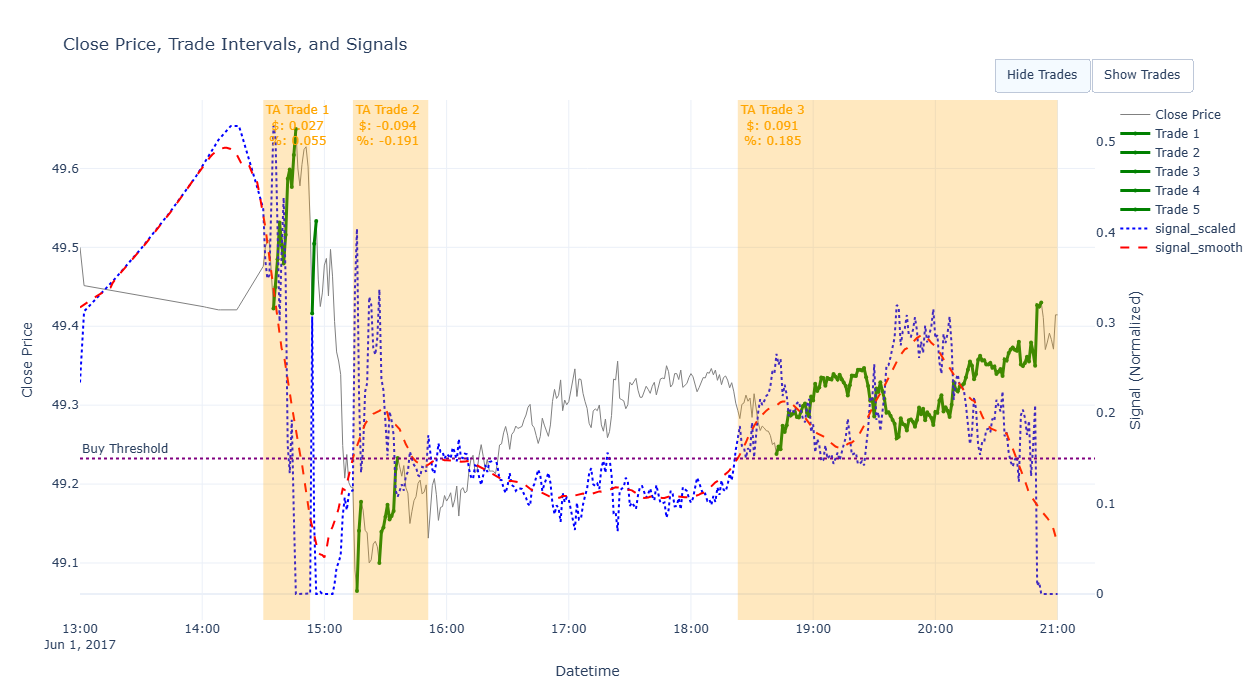


=== Performance for 2017-06-01 00:00:00 ===
Strategy Return ($): 0.025
Strategy Return (%): 0.051
Buy & Hold Return ($): -0.091
Buy & Hold Return (%): -0.184
Strategy Return Difference ($): 0.116
Strategy Return Improvement (%): 0.235
Trades Returns ($): [0.027, -0.094, 0.091]
Trades Returns (%): [0.055, -0.191, 0.185]

=== Processing trading day 2017-06-02 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


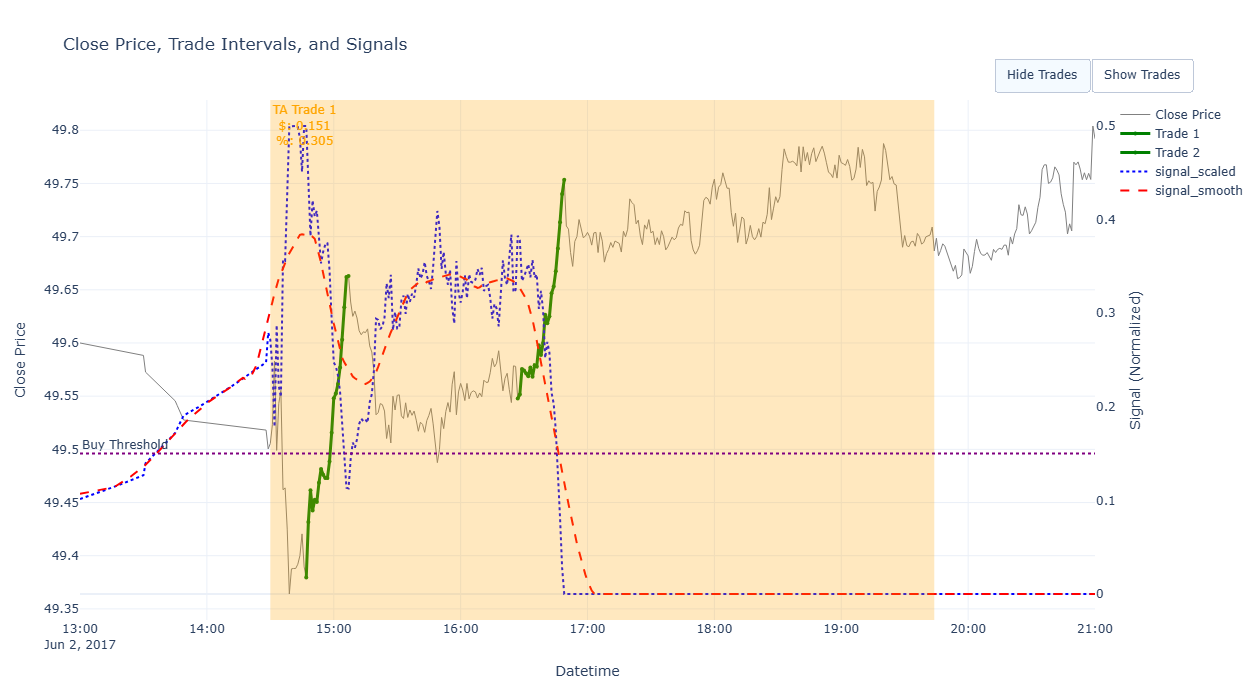


=== Performance for 2017-06-02 00:00:00 ===
Strategy Return ($): 0.151
Strategy Return (%): 0.305
Buy & Hold Return ($): 0.269
Buy & Hold Return (%): 0.543
Strategy Return Difference ($): -0.118
Strategy Return Improvement (%): -0.238
Trades Returns ($): [0.151]
Trades Returns (%): [0.305]

=== Processing trading day 2017-06-05 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


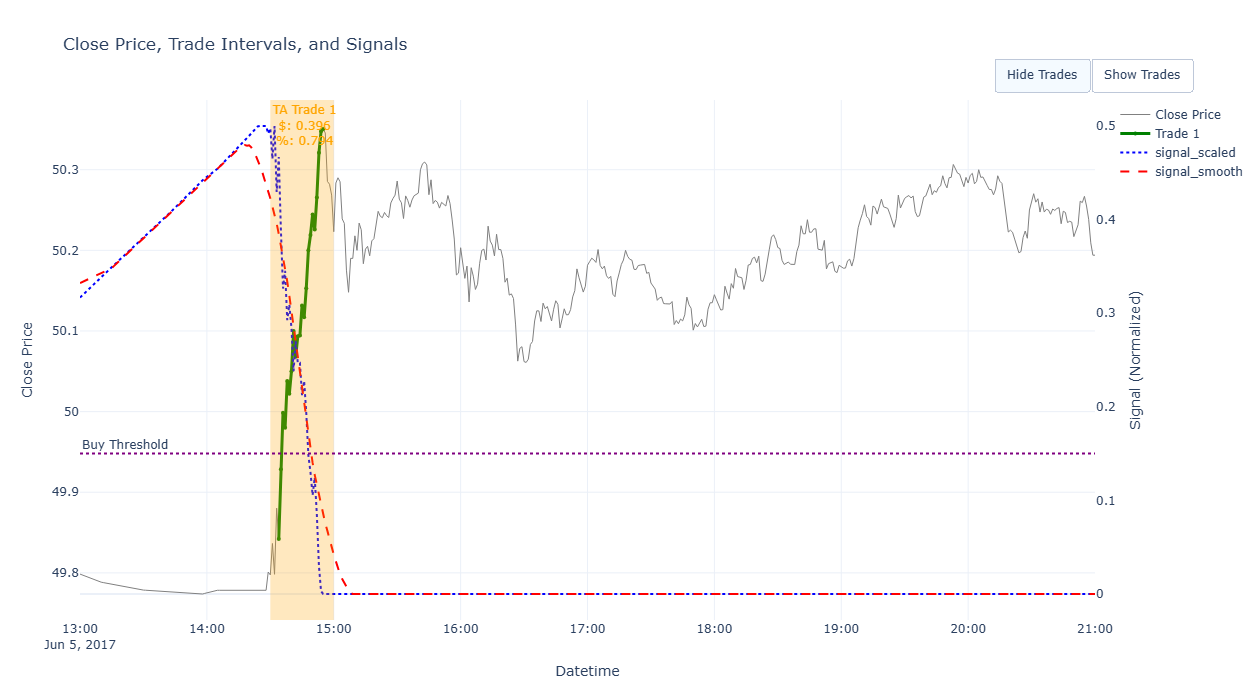


=== Performance for 2017-06-05 00:00:00 ===
Strategy Return ($): 0.396
Strategy Return (%): 0.795
Buy & Hold Return ($): 0.366
Buy & Hold Return (%): 0.736
Strategy Return Difference ($): 0.03
Strategy Return Improvement (%): 0.059
Trades Returns ($): [0.396]
Trades Returns (%): [0.794]

=== Processing trading day 2017-06-06 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


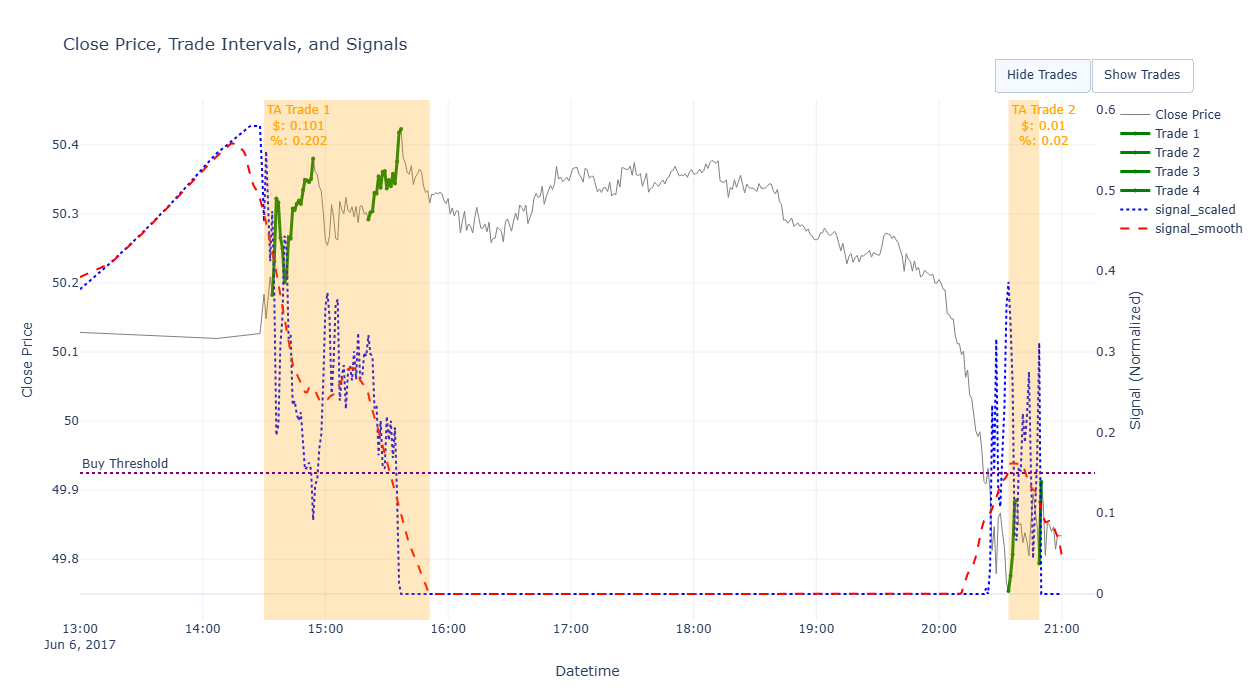


=== Performance for 2017-06-06 00:00:00 ===
Strategy Return ($): 0.112
Strategy Return (%): 0.223
Buy & Hold Return ($): -0.38
Buy & Hold Return (%): -0.757
Strategy Return Difference ($): 0.492
Strategy Return Improvement (%): 0.98
Trades Returns ($): [0.101, 0.01]
Trades Returns (%): [0.202, 0.02]

=== Processing trading day 2017-06-07 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


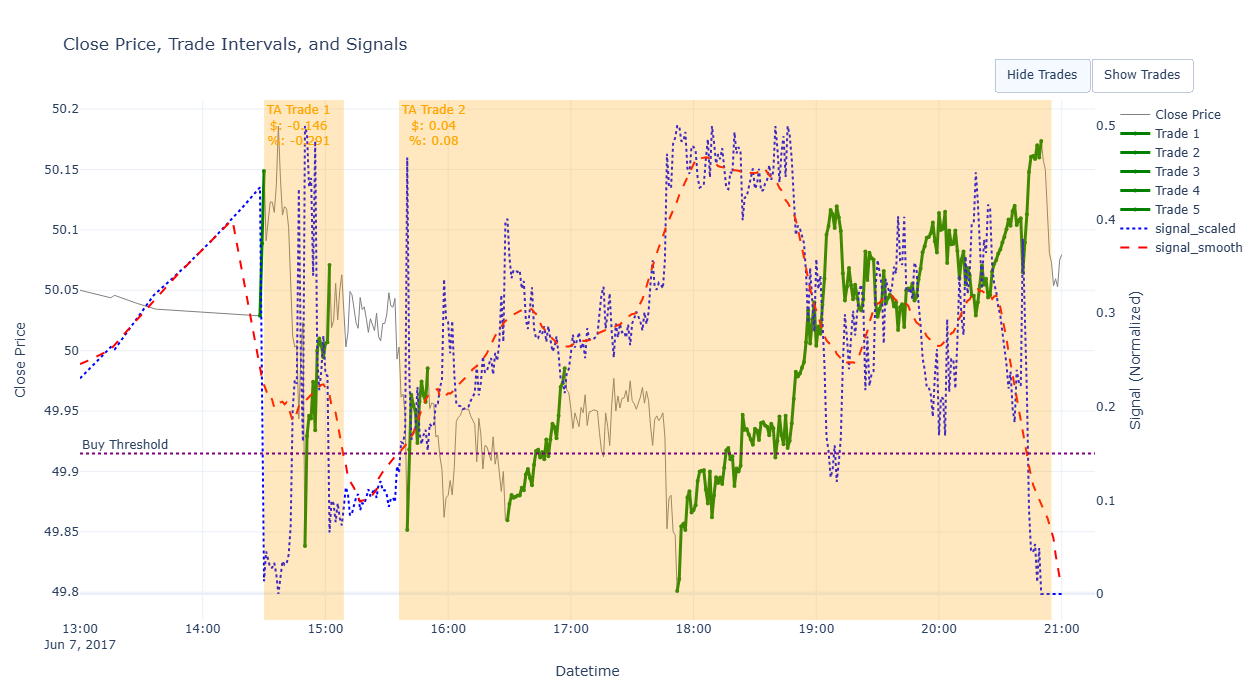


=== Performance for 2017-06-07 00:00:00 ===
Strategy Return ($): -0.106
Strategy Return (%): -0.211
Buy & Hold Return ($): -0.104
Buy & Hold Return (%): -0.207
Strategy Return Difference ($): -0.002
Strategy Return Improvement (%): -0.004
Trades Returns ($): [-0.146, 0.04]
Trades Returns (%): [-0.291, 0.08]

=== Processing trading day 2017-06-08 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


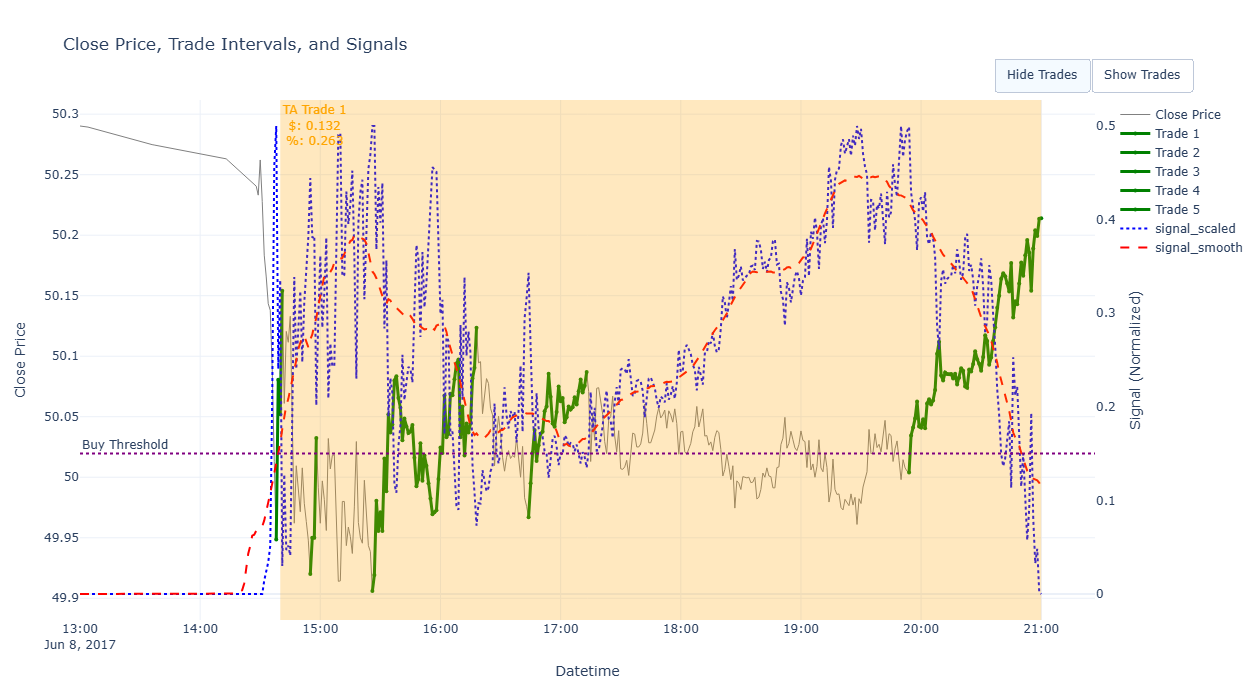


=== Performance for 2017-06-08 00:00:00 ===
Strategy Return ($): 0.131
Strategy Return (%): 0.261
Buy & Hold Return ($): -0.079
Buy & Hold Return (%): -0.157
Strategy Return Difference ($): 0.21
Strategy Return Improvement (%): 0.417
Trades Returns ($): [0.132]
Trades Returns (%): [0.263]

=== Processing trading day 2017-06-09 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


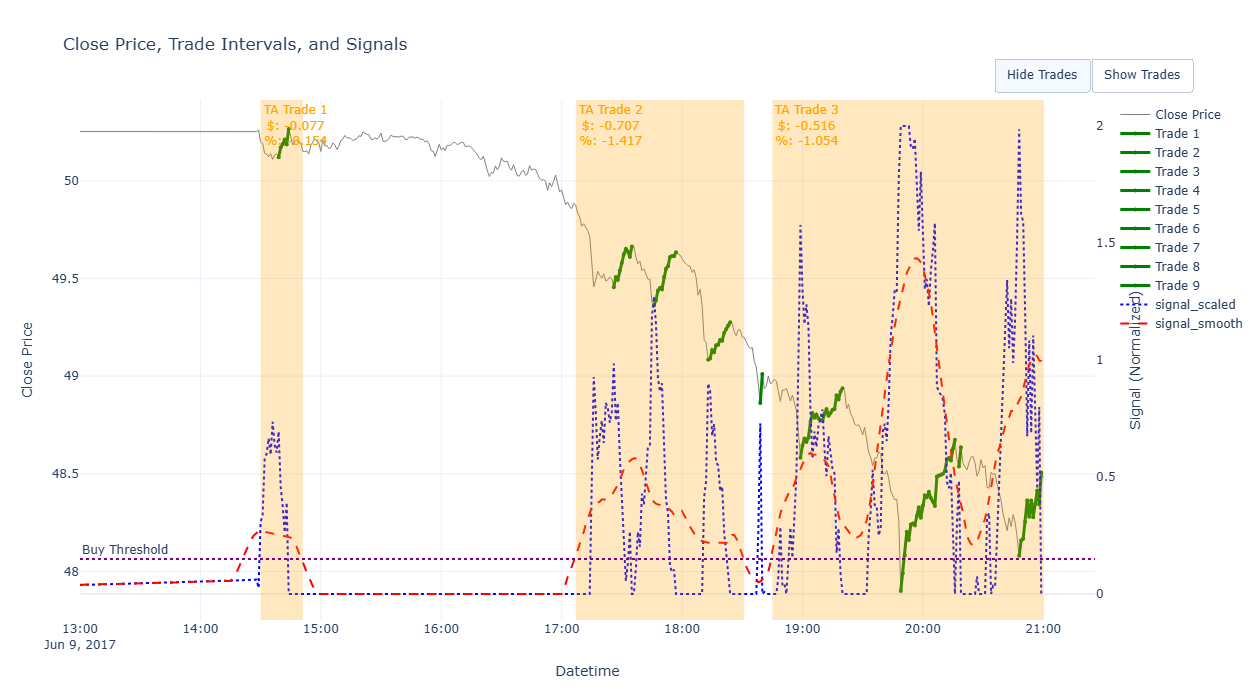


=== Performance for 2017-06-09 00:00:00 ===
Strategy Return ($): -1.275
Strategy Return (%): -2.539
Buy & Hold Return ($): -1.722
Buy & Hold Return (%): -3.429
Strategy Return Difference ($): 0.447
Strategy Return Improvement (%): 0.889
Trades Returns ($): [-0.077, -0.707, -0.516]
Trades Returns (%): [-0.154, -1.417, -1.054]

=== Processing trading day 2017-06-12 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


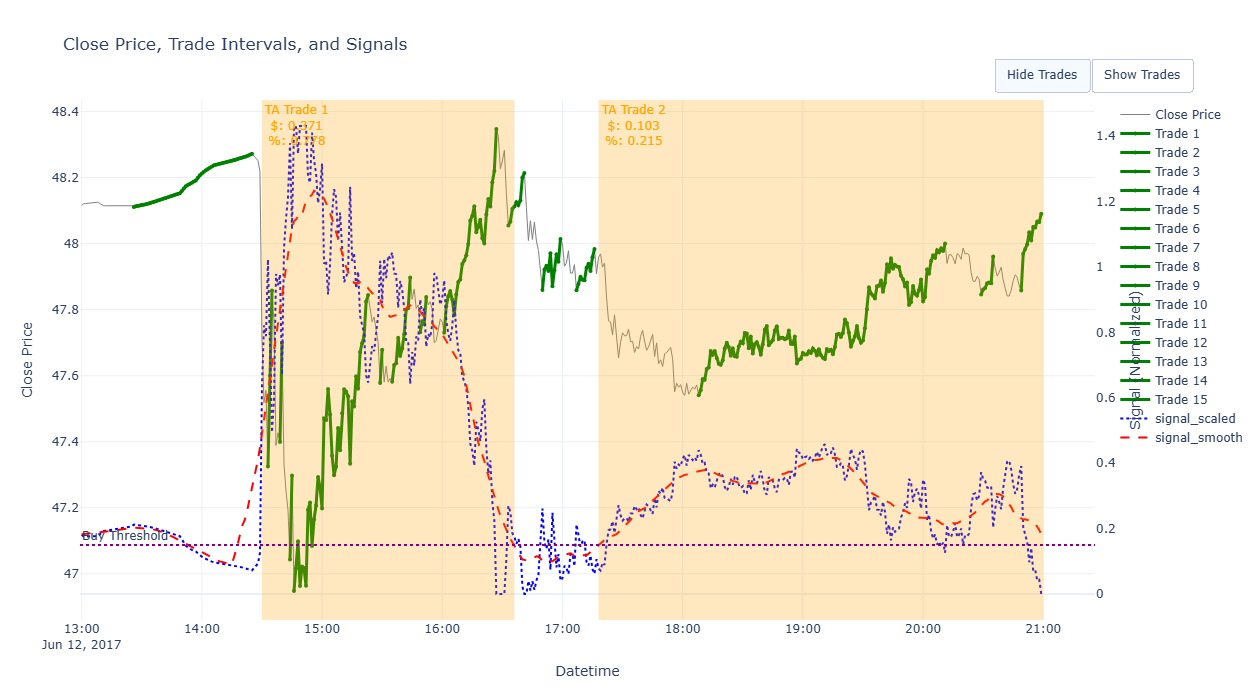


=== Performance for 2017-06-12 00:00:00 ===
Strategy Return ($): 0.475
Strategy Return (%): 0.995
Buy & Hold Return ($): 0.35
Buy & Hold Return (%): 0.733
Strategy Return Difference ($): 0.125
Strategy Return Improvement (%): 0.262
Trades Returns ($): [0.371, 0.103]
Trades Returns (%): [0.778, 0.215]

=== Processing trading day 2017-06-13 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


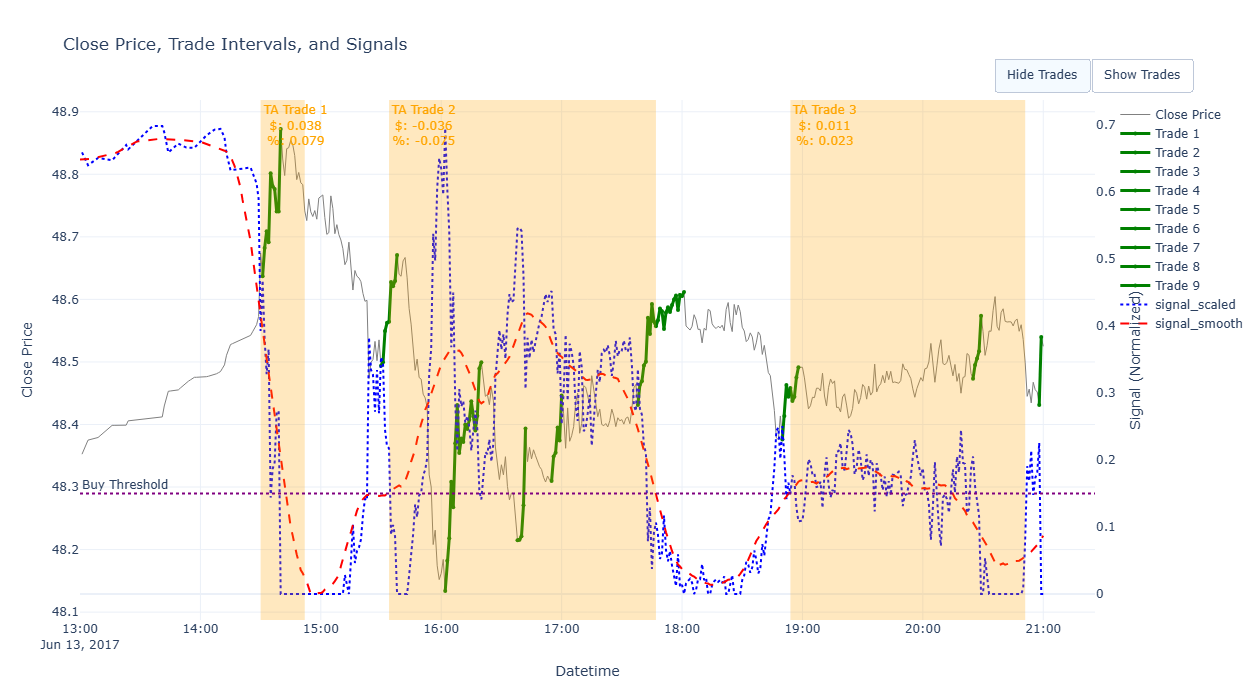


=== Performance for 2017-06-13 00:00:00 ===
Strategy Return ($): 0.013
Strategy Return (%): 0.027
Buy & Hold Return ($): -0.163
Buy & Hold Return (%): -0.335
Strategy Return Difference ($): 0.176
Strategy Return Improvement (%): 0.362
Trades Returns ($): [0.038, -0.036, 0.011]
Trades Returns (%): [0.079, -0.075, 0.023]

=== Processing trading day 2017-06-14 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


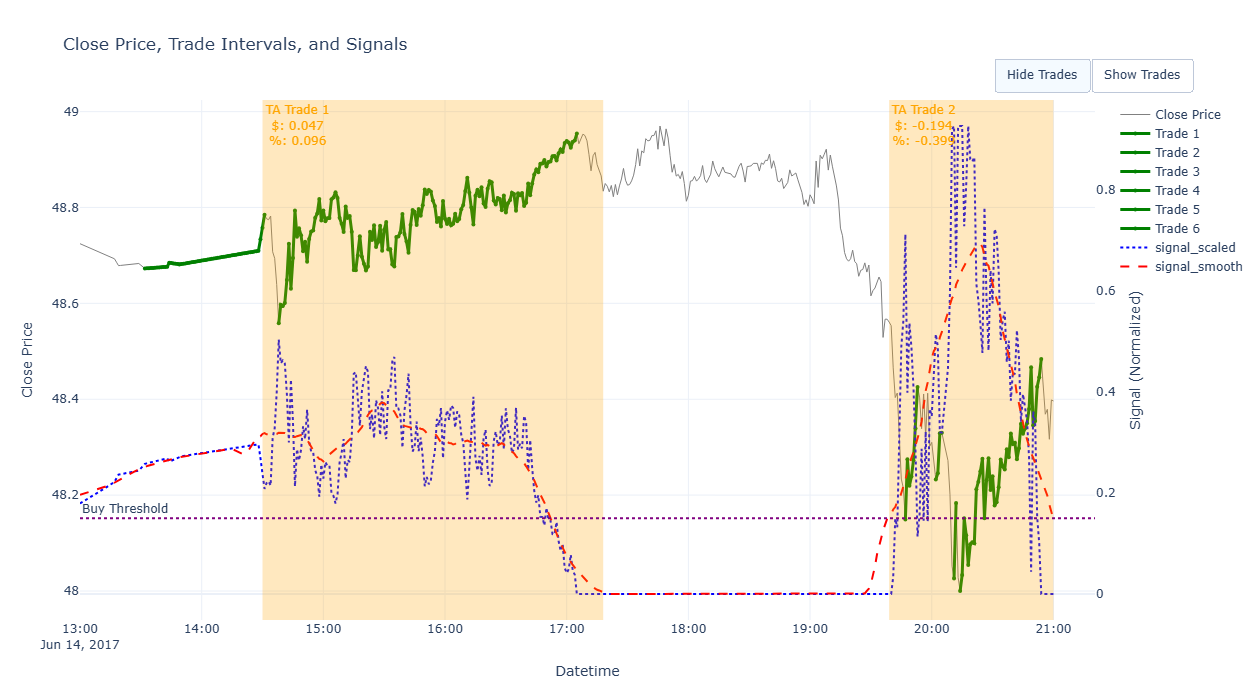


=== Performance for 2017-06-14 00:00:00 ===
Strategy Return ($): -0.145
Strategy Return (%): -0.297
Buy & Hold Return ($): -0.389
Buy & Hold Return (%): -0.797
Strategy Return Difference ($): 0.244
Strategy Return Improvement (%): 0.5
Trades Returns ($): [0.047, -0.194]
Trades Returns (%): [0.096, -0.399]

=== Processing trading day 2017-06-15 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


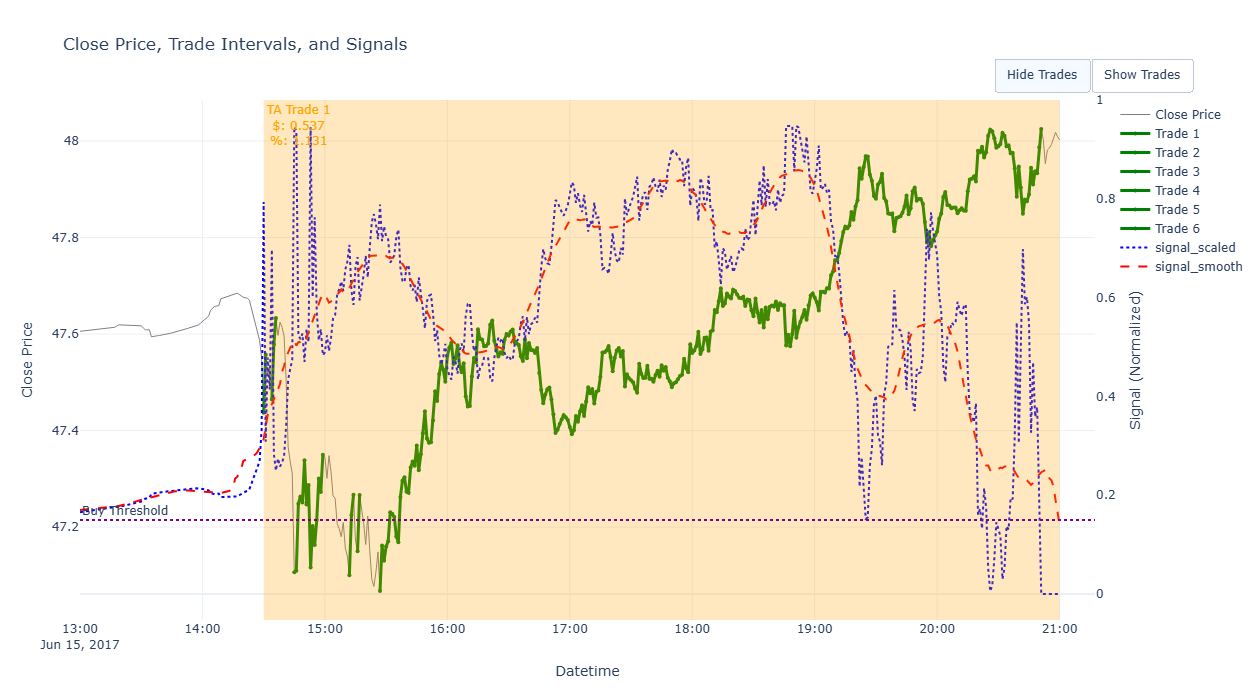


=== Performance for 2017-06-15 00:00:00 ===
Strategy Return ($): 0.543
Strategy Return (%): 1.144
Buy & Hold Return ($): 0.543
Buy & Hold Return (%): 1.145
Strategy Return Difference ($): -0.0
Strategy Return Improvement (%): -0.001
Trades Returns ($): [0.537]
Trades Returns (%): [1.131]

=== Processing trading day 2017-06-16 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


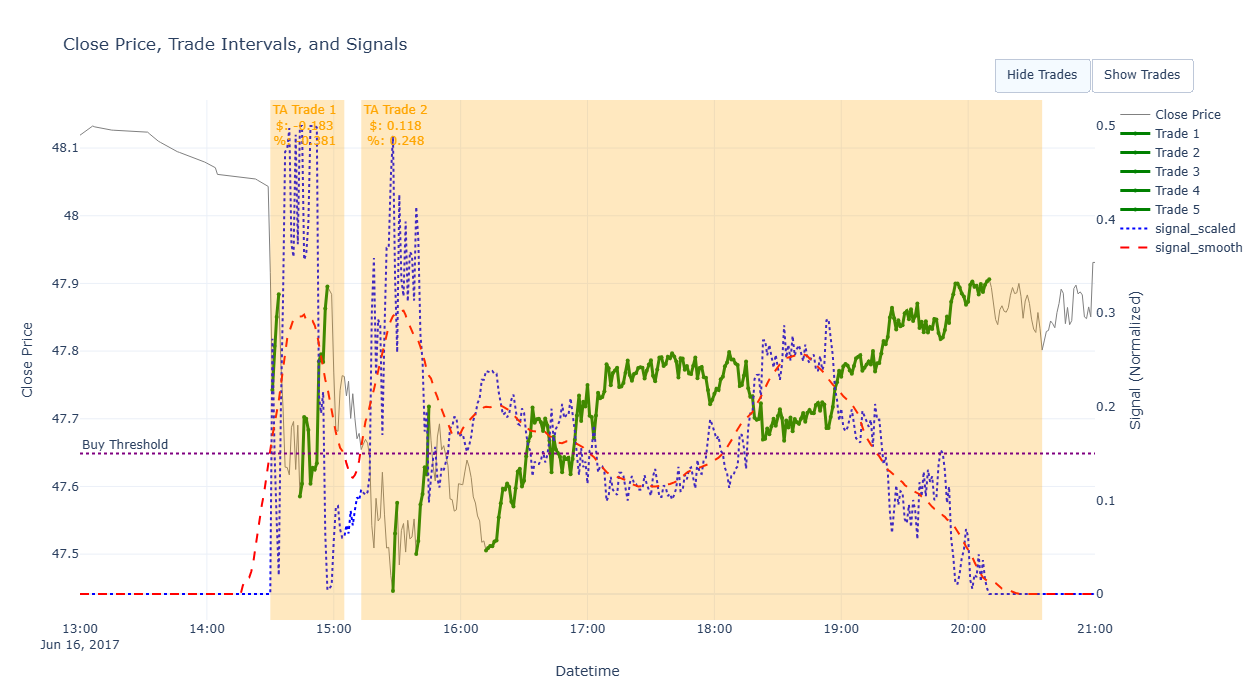


=== Performance for 2017-06-16 00:00:00 ===
Strategy Return ($): -0.064
Strategy Return (%): -0.134
Buy & Hold Return ($): -0.014
Buy & Hold Return (%): -0.03
Strategy Return Difference ($): -0.05
Strategy Return Improvement (%): -0.104
Trades Returns ($): [-0.183, 0.118]
Trades Returns (%): [-0.381, 0.248]

=== Processing trading day 2017-06-19 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


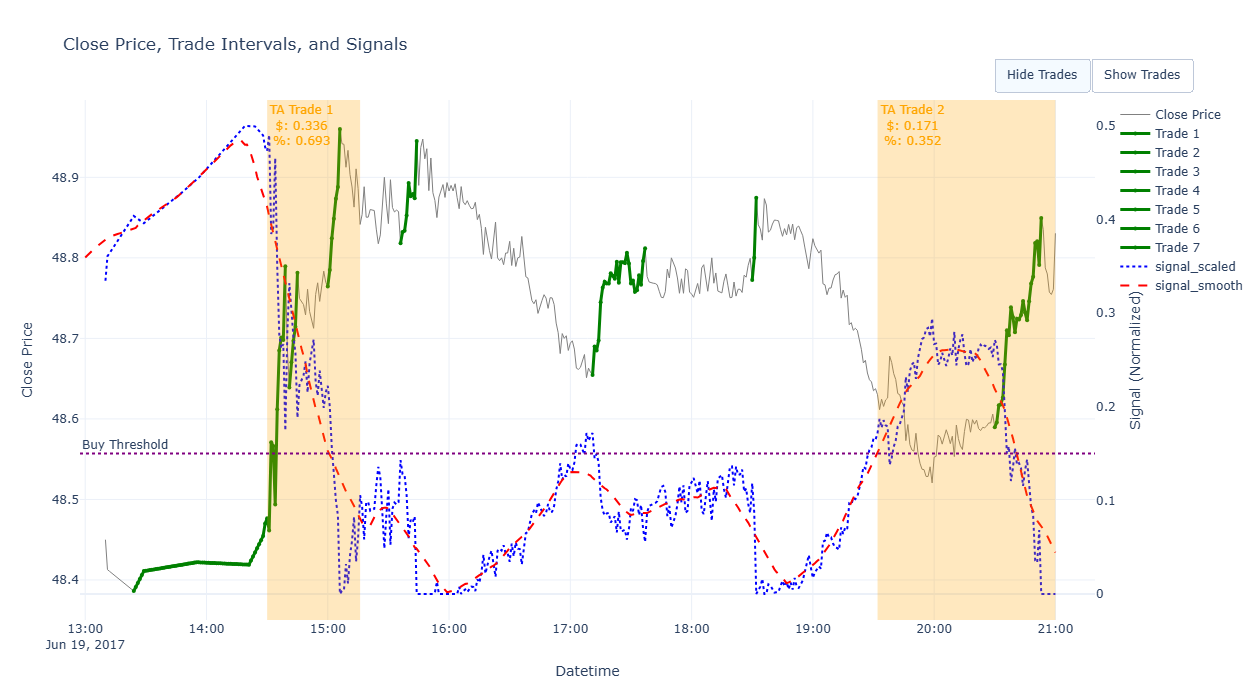


=== Performance for 2017-06-19 00:00:00 ===
Strategy Return ($): 0.438
Strategy Return (%): 0.903
Buy & Hold Return ($): 0.255
Buy & Hold Return (%): 0.527
Strategy Return Difference ($): 0.183
Strategy Return Improvement (%): 0.377
Trades Returns ($): [0.336, 0.171]
Trades Returns (%): [0.693, 0.352]

=== Processing trading day 2017-06-20 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


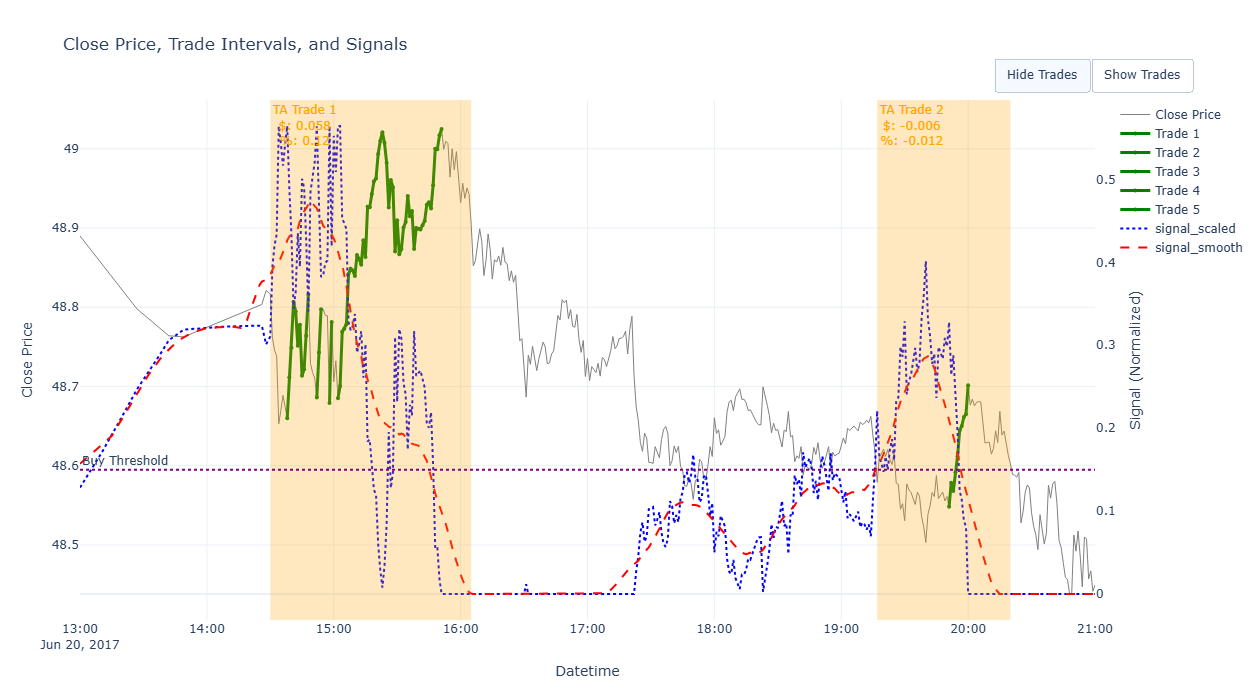


=== Performance for 2017-06-20 00:00:00 ===
Strategy Return ($): 0.053
Strategy Return (%): 0.109
Buy & Hold Return ($): -0.404
Buy & Hold Return (%): -0.828
Strategy Return Difference ($): 0.457
Strategy Return Improvement (%): 0.937
Trades Returns ($): [0.058, -0.006]
Trades Returns (%): [0.12, -0.012]

=== Processing trading day 2017-06-21 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


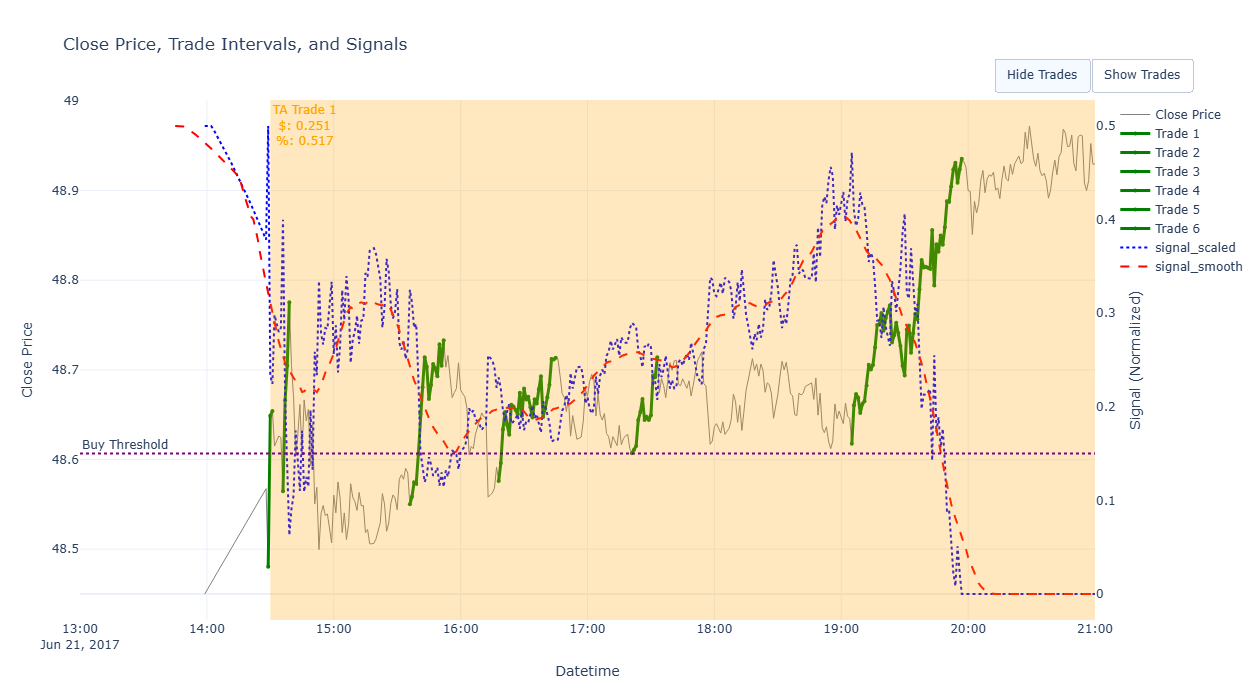


=== Performance for 2017-06-21 00:00:00 ===
Strategy Return ($): 0.251
Strategy Return (%): 0.516
Buy & Hold Return ($): 0.251
Buy & Hold Return (%): 0.517
Strategy Return Difference ($): -0.0
Strategy Return Improvement (%): -0.001
Trades Returns ($): [0.251]
Trades Returns (%): [0.517]

=== Processing trading day 2017-06-22 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


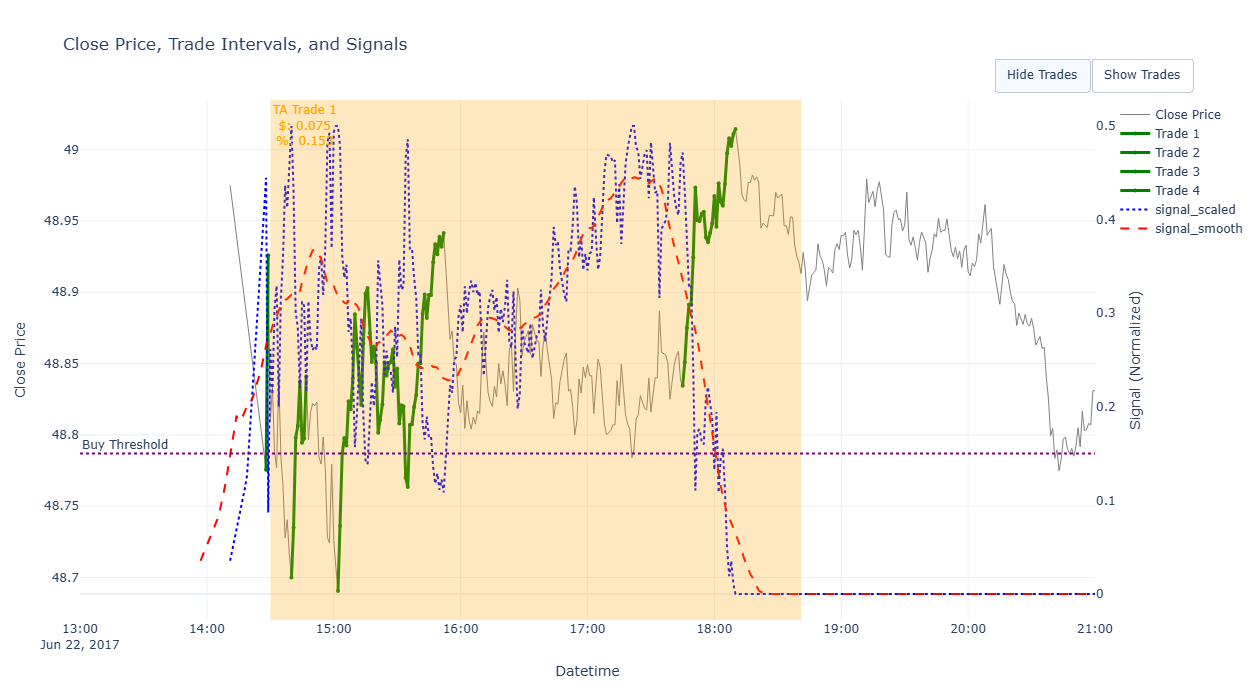


=== Performance for 2017-06-22 00:00:00 ===
Strategy Return ($): 0.075
Strategy Return (%): 0.154
Buy & Hold Return ($): -0.007
Buy & Hold Return (%): -0.015
Strategy Return Difference ($): 0.082
Strategy Return Improvement (%): 0.169
Trades Returns ($): [0.075]
Trades Returns (%): [0.153]

=== Processing trading day 2017-06-23 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


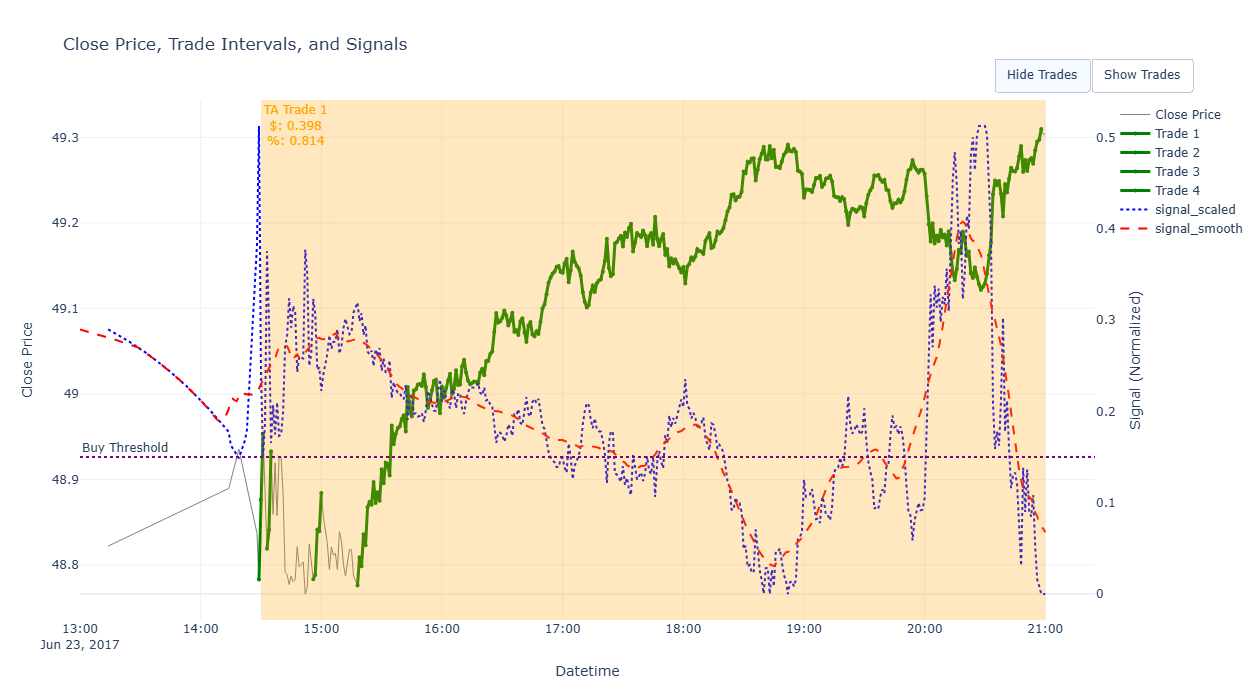


=== Performance for 2017-06-23 00:00:00 ===
Strategy Return ($): 0.398
Strategy Return (%): 0.814
Buy & Hold Return ($): 0.398
Buy & Hold Return (%): 0.814
Strategy Return Difference ($): 0.0
Strategy Return Improvement (%): 0.0
Trades Returns ($): [0.398]
Trades Returns (%): [0.814]

=== Processing trading day 2017-06-26 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


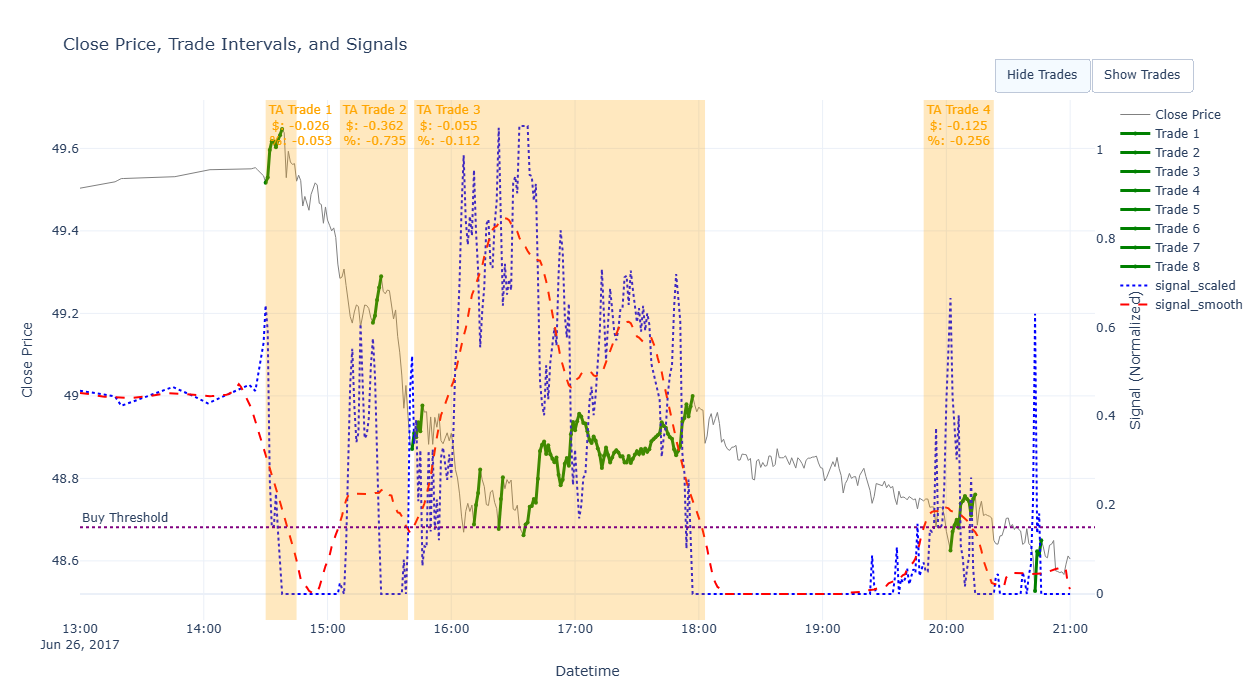


=== Performance for 2017-06-26 00:00:00 ===
Strategy Return ($): -0.568
Strategy Return (%): -1.147
Buy & Hold Return ($): -0.934
Buy & Hold Return (%): -1.887
Strategy Return Difference ($): 0.366
Strategy Return Improvement (%): 0.74
Trades Returns ($): [-0.026, -0.362, -0.055, -0.125]
Trades Returns (%): [-0.053, -0.735, -0.112, -0.256]

=== Processing trading day 2017-06-27 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


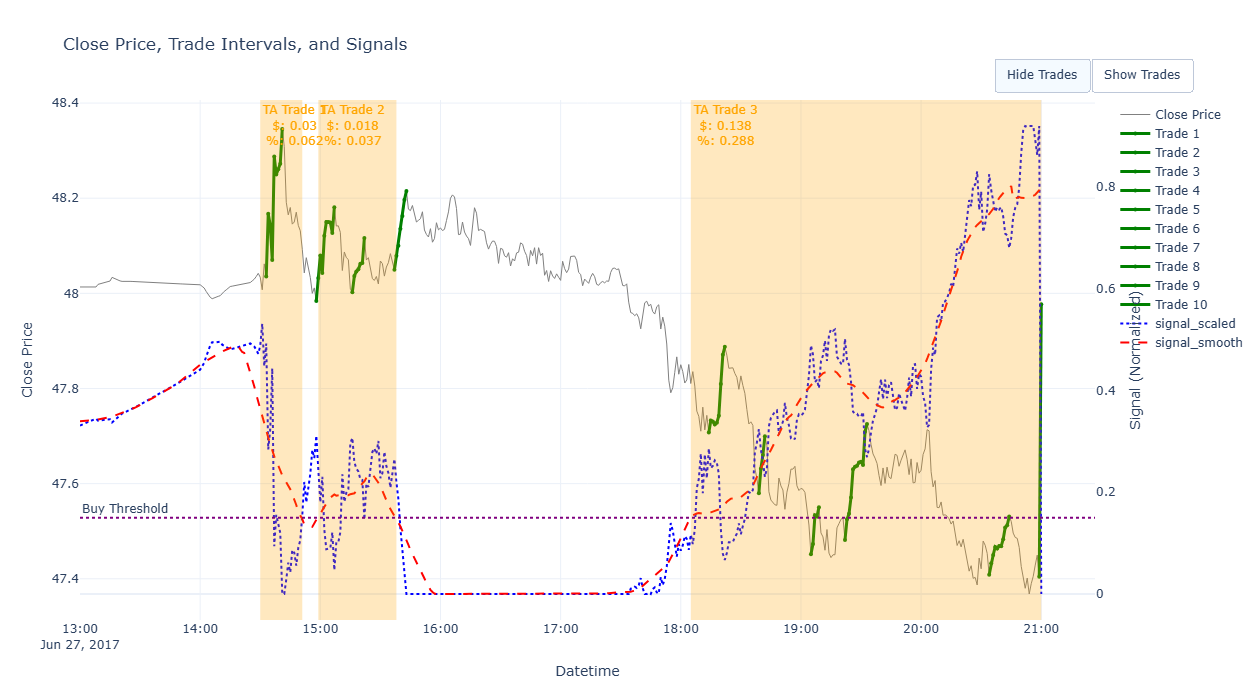


=== Performance for 2017-06-27 00:00:00 ===
Strategy Return ($): -0.387
Strategy Return (%): -0.805
Buy & Hold Return ($): -0.658
Buy & Hold Return (%): -1.37
Strategy Return Difference ($): 0.271
Strategy Return Improvement (%): 0.564
Trades Returns ($): [0.03, 0.018, 0.138]
Trades Returns (%): [0.062, 0.037, 0.288]

=== Processing trading day 2017-06-28 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


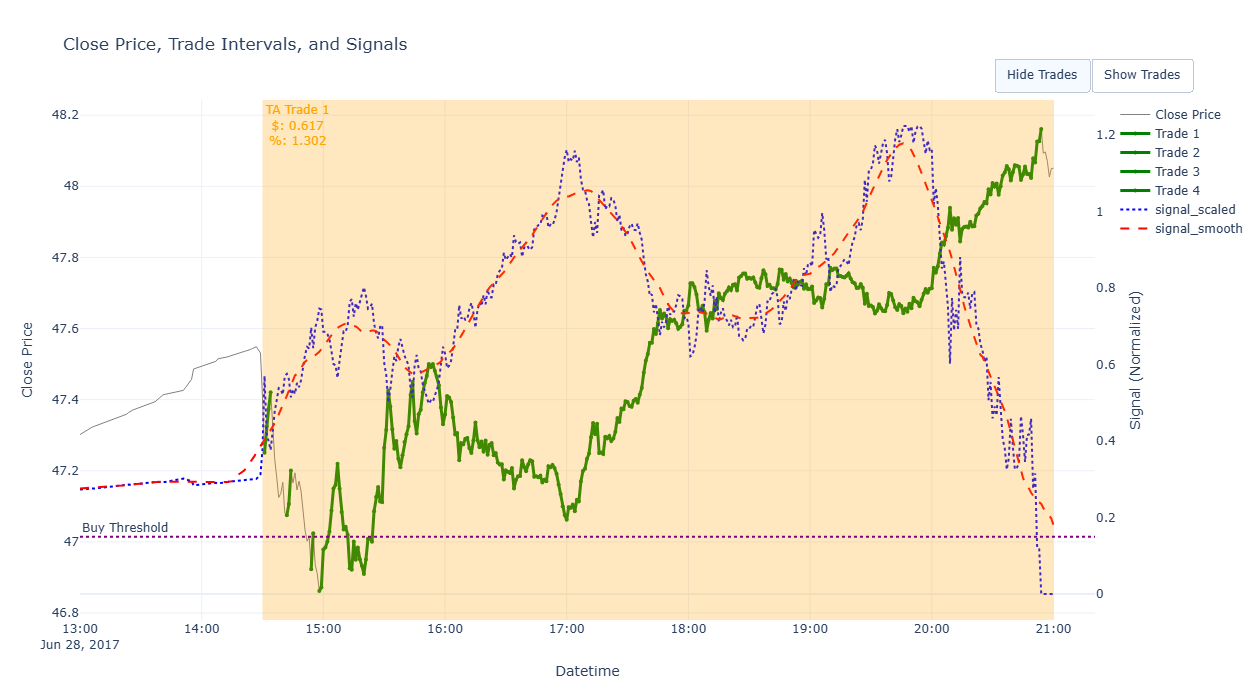


=== Performance for 2017-06-28 00:00:00 ===
Strategy Return ($): 0.617
Strategy Return (%): 1.301
Buy & Hold Return ($): 0.617
Buy & Hold Return (%): 1.301
Strategy Return Difference ($): 0.0
Strategy Return Improvement (%): 0.0
Trades Returns ($): [0.617]
Trades Returns (%): [1.302]

=== Processing trading day 2017-06-29 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


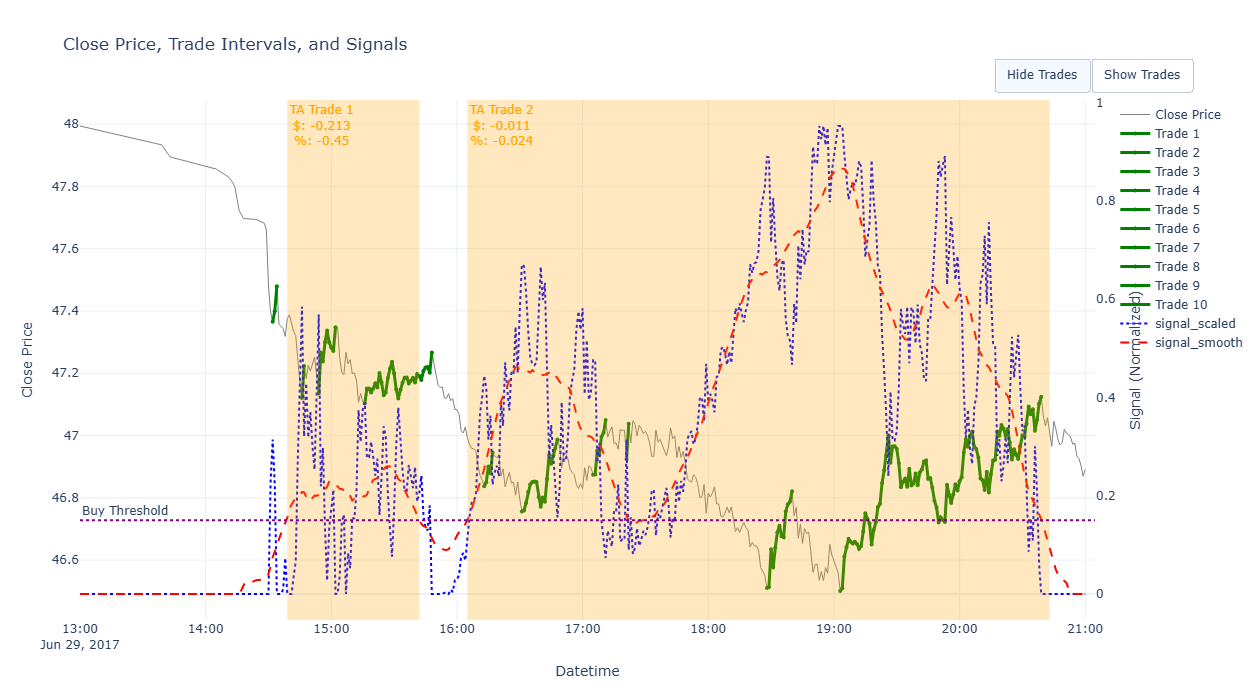


=== Performance for 2017-06-29 00:00:00 ===
Strategy Return ($): -0.225
Strategy Return (%): -0.474
Buy & Hold Return ($): -0.639
Buy & Hold Return (%): -1.346
Strategy Return Difference ($): 0.414
Strategy Return Improvement (%): 0.872
Trades Returns ($): [-0.213, -0.011]
Trades Returns (%): [-0.45, -0.024]

=== Processing trading day 2017-06-30 ===
Step B1: identify_trades_daily …
Step B2: add_trade_signal_to_results …
Step B3: simulate_trading …


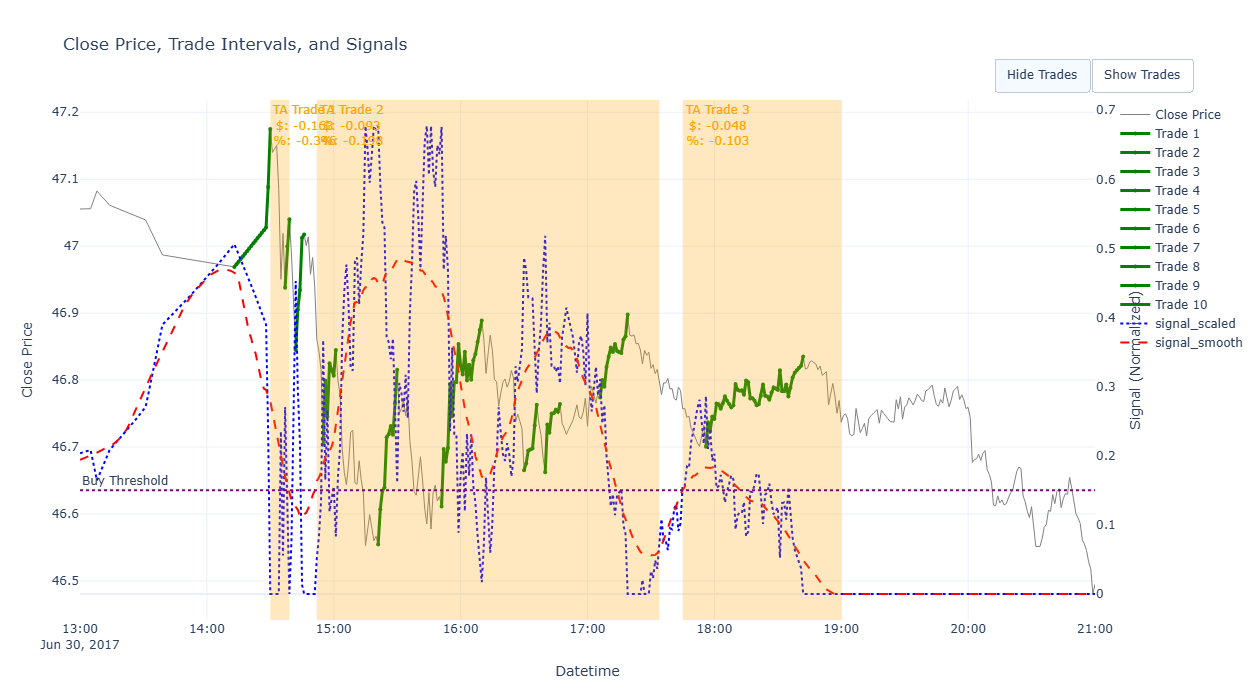


=== Performance for 2017-06-30 00:00:00 ===
Strategy Return ($): -0.304
Strategy Return (%): -0.644
Buy & Hold Return ($): -0.723
Buy & Hold Return (%): -1.531
Strategy Return Difference ($): 0.419
Strategy Return Improvement (%): 0.887
Trades Returns ($): [-0.163, -0.093, -0.048]
Trades Returns (%): [-0.346, -0.198, -0.103]

=== Overall Summary (2017-06) ===
One-time buy&hold gain: buy at 2017-06-01 → 49.17325, sell at 2017-06-30 → 46.49355   (gain = -2.680)

{'Buy & Hold – each day ($)': -3.258,
 'Buy & Hold – each day (%)': -6.557,
 'Strategy Return ($)': 0.604,
 'Strategy Return (%)': 1.347,
 'Strategy Return Difference ($)': 3.862,
 'Strategy Return Improvement (%)': 7.904,
 'Trades Returns ($)': '43 trades',
 'Trades Returns (%)': '43 trades'}


In [5]:
df_fin = saveDF_checkDAY(
                        df=df,
                        ticker=params.ticker,
                        min_prof_thr=params.min_prof_thr_man, 
                        max_down_prop=params.max_down_prop_man, 
                        gain_tightening_factor=params.gain_tightening_factor_man,
                        smooth_win_sig=params.smooth_win_sig_man, 
                        pre_entry_decay=params.pre_entry_decay_man, 
                        buy_threshold=params.buy_threshold_man, 
                        trailing_stop_thresh=params.trailing_stop_thresh_man,
                        merging_retracement_thr=params.merging_retracement_thr_man, 
                        merging_time_gap_thr=params.merging_time_gap_thr_man,
                        reference_gain=reference_gain,
                        date_to_check=date_to_check
                        )

df_fin